In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg

import pandas as pd
from sklearn.decomposition import PCA
import pickle as pkl
import os
from einops import rearrange
from datasets import load_dataset

import matplotlib.patches as patches
from sklearn.covariance import EmpiricalCovariance

from sklearn.cluster import KMeans
from collections import Counter


import sys
sys.path.append('..')
from utils import get_separated_activations



/home/jxf/anaconda3/envs/iti/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_separated_activations(labels, head_wise_activations, categories): 

    # separate activations by question
    dataset=load_dataset('truthful_qa', 'multiple_choice')['validation']
    actual_labels = []
    for i in range(len(dataset)):
        actual_labels.append(dataset[i]['mc2_targets']['labels'])
    

    idxs_to_split_at = np.cumsum([len(x) for x in actual_labels])        

    labels = list(labels)
    categories = list(categories)
    separated_labels = []
    separated_categories = []
    for i in range(len(idxs_to_split_at)):
        if i == 0:
            separated_labels.append(labels[:idxs_to_split_at[i]])
            separated_categories.append(categories[:idxs_to_split_at[i]])
        else:
            separated_labels.append(labels[idxs_to_split_at[i-1]:idxs_to_split_at[i]])
            separated_categories.append(categories[idxs_to_split_at[i-1]:idxs_to_split_at[i]])

    separated_head_wise_activations = np.split(head_wise_activations, idxs_to_split_at)

    return separated_head_wise_activations, separated_labels, separated_categories, idxs_to_split_at


In [17]:
def plot_kde(matrix, label, row_i, col_i):
    plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei'] 
    plt.rcParams.update({'font.size': 14})
    data = matrix[:, row_i, col_i, :]
    pca = PCA(n_components=2, random_state=42)
    reduced_data = pca.fit_transform(data)
    label_map = {1: "Truthful", 0: "False"}
    mapped_labels = [label_map[label] for label in label]
    palette = {"Truthful": "green", "False": "red"}
    # palette = {"Truthful": "green", "False": "#EE7785"}


    df = pd.DataFrame({'PC1': reduced_data[:, 0], 'PC2': reduced_data[:, 1], 'Label': mapped_labels})

    g = sns.jointplot(data=df, x="PC1", y="PC2", hue="Label", kind="kde", fill=False, palette=palette)
    

    # Adjust the plot titles and labels
    g.set_axis_labels(f'PC1', f'PC2')
    # g.fig.suptitle(f'(b) Kernel Density Estimate for Layer {row_i}, Head {6} at the end position')
    # g.fig.suptitle(f'Kernel Density Estimate for Layer {row_i}, Head {col_i}')
    g.fig.suptitle(f'层{row_i}-注意力头{col_i} 上的核密度估计图')
    # g.fig.suptitle(f'(b) 层{11}-注意力头6 末尾位置的核密度估计图')
    plt.savefig(f'kde_{row_i}_{col_i}.png')
    plt.show()



In [4]:
def get_sample_directions(separated_labels, separated_head_wise_activations, separated_categories, row_i, col_i):
    mean_diffs = []
    categories = []
    separated_head_wise_activations_sel = [a[:, row_i, col_i, :] for a in separated_head_wise_activations]
    for labels, activations, category in zip(separated_labels, separated_head_wise_activations_sel, separated_categories):
        # 计算标签为1和0的均值差
        mean_diff = np.mean(activations[np.array(labels) == 1], axis=0) - np.mean(activations[np.array(labels) == 0], axis=0)
        mean_diffs.append(mean_diff)
        categories.append(category[0])  # 假设每个数组的类别都是一致的
    
    return mean_diffs, categories

In [5]:
def direction_kmeans_categorie_dist(directions, categories, n_clusters=5):
    X = np.array(directions)

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    labels = kmeans.labels_

    clusters = {i: [] for i in range(n_clusters)}
    for label, category in zip(labels, categories):
        clusters[label].append(category)
    
    # 确定所有图中都将出现的类别集合
    all_categories = set()
    for category in categories:
        all_categories.add(category)

    # 将类别转换为列表并排序
    all_categories = sorted(list(all_categories))
    total_counts = Counter(categories)
    cluster_percentages = {}

    for cluster_id, cluster_categories in clusters.items():
        cluster_counter = Counter(cluster_categories)
        percentages = {category: (cluster_counter[category] / total_counts[category]) * 100 
                    for category in all_categories}
        cluster_percentages[cluster_id] = percentages
    
    # 可视化每个群组中的类别分布
    fig, axs = plt.subplots(n_clusters, figsize=(10, 6), sharey=True, sharex=True)

    for i, cluster_id in enumerate(cluster_percentages):
        percentages = [cluster_percentages[cluster_id].get(category, 0) for category in all_categories]

        axs[i].bar(all_categories, percentages, color='skyblue')
        axs[i].set_title(f'Cluster {cluster_id}')


    fig.text(-0.01, 0.6, '% of Category in Cluster', va='center', rotation='vertical')
        
        # 设置横坐标标签垂直显示
    axs[-1].set_xticklabels(all_categories, rotation=90)

    plt.tight_layout()
    plt.show()
    

In [6]:
def plot_direction_dist(directions, categories):
    X = np.array(directions)

    pca = PCA(n_components=2)
    X_r = pca.fit_transform(X)

    unique_categories = list(set(categories))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_categories)))

    # 绘制每个类别
    for color, category in zip(colors, unique_categories):
        data = X_r[np.array(categories) == category]
        plt.scatter(data[:, 0], data[:, 1], color=color, alpha=0.8, label=category)

        # 计算每个类别数据的协方差
        cov = EmpiricalCovariance().fit(data).covariance_

        # 计算协方差矩阵的特征值和特征向量
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]

        # 计算椭圆的宽度、高度和旋转角度
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
        width, height = 2 * np.sqrt(vals)
        ellipse = patches.Ellipse(xy=(np.mean(data[:, 0]), np.mean(data[:, 1])),
                                width=width, height=height, angle=theta,
                                color=color, alpha=0.5)

        plt.gca().add_patch(ellipse)

    # 将图例放在图形外的右侧
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title('PCA of Mean Differences with Confidence Ellipses')
    plt.show()


In [7]:
num_heads = 32

activation_head_wise = pkl.load(open('/data/jxf/activations/llama_7B_tqa_mc2_all_100_head_wise.pkl', 'rb'))
activation_head_wise = np.array(activation_head_wise)
activation_head_wise = rearrange(activation_head_wise, 'b l (h d) -> b l h d', h = num_heads)
activation_labels = np.load('/data/jxf/activations/llama_7B_tqa_mc2_all_100_labels.npy')
activation_categories = pkl.load(open('/data/jxf/activations/llama_7B_tqa_mc2_all_categories.pkl', 'rb'))

# 可视化正负样本分布

In [8]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.decomposition import PCA
# import pandas as pd

# def plot_kde(matrix, label, row_i, col_i, ax):
#     plt.rcParams.update({'font.size': 16})
#     data = matrix[:, row_i, col_i, :]
#     pca = PCA(n_components=2, random_state=42)
#     reduced_data = pca.fit_transform(data)
#     label_map = {1: "Truthful", 0: "False"}
#     mapped_labels = [label_map[label] for label in label]
#     palette = {"Truthful": "green", "False": "red"}  # 浅绿和浅红

#     df = pd.DataFrame({'PC1': reduced_data[:, 0], 'PC2': reduced_data[:, 1], 'Label': mapped_labels})

#     sns.kdeplot(data=df, x="PC1", y="PC2", hue="Label", fill=False, palette=palette, ax=ax)
#     # sns.jointplot(data=df, x="PC1", y="PC2", hue="Label", kind="kde", fill=False, palette=palette, ax=ax)
#     ax.set_title(f'Kernel Density Estimate for Layer {row_i}, Head {col_i}')

# # 创建一个 2x2 的图表网格
# fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# plot_kde(activation_head_wise, activation_labels, 11, 6, axes[0, 0])
# plot_kde(activation_head_wise, activation_labels, 12, 3, axes[0, 1])
# plot_kde(activation_head_wise, activation_labels, 18, 0, axes[1, 0])
# plot_kde(activation_head_wise, activation_labels, 17, 1, axes[1, 1])

# plt.tight_layout()
# plt.savefig('activations_kde.pdf', format='pdf')
# plt.show()

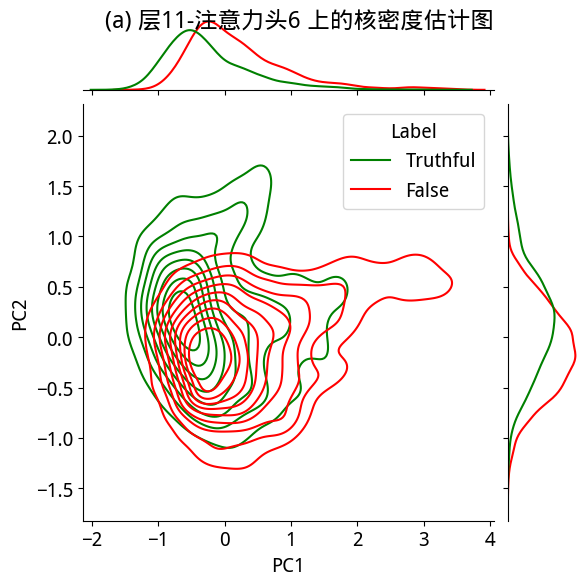

In [10]:
plot_kde(activation_head_wise, activation_labels, 11, 6)

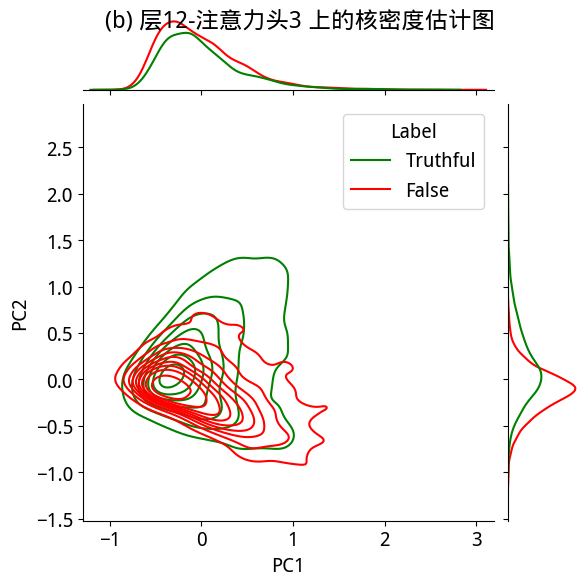

In [12]:
plot_kde(activation_head_wise, activation_labels, 12, 3)

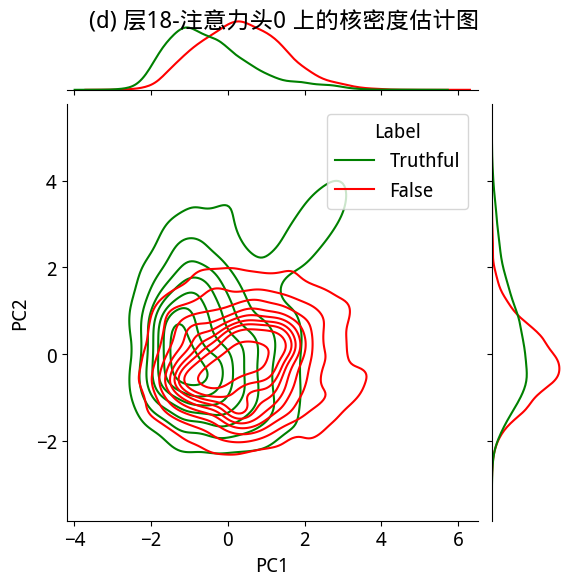

In [16]:
plot_kde(activation_head_wise, activation_labels, 18, 0)

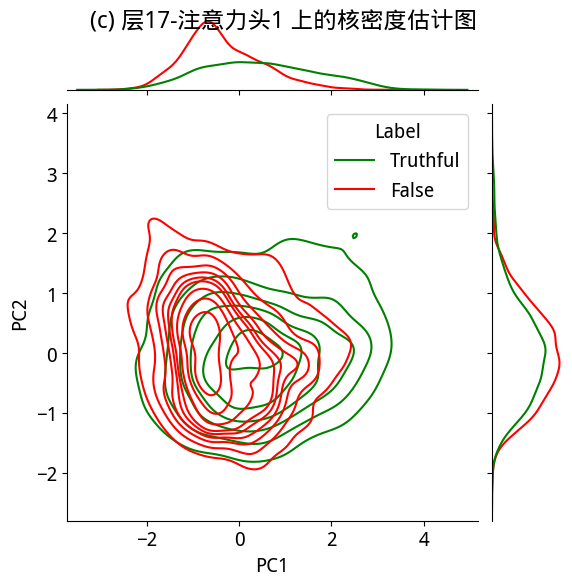

In [18]:
plot_kde(activation_head_wise, activation_labels, 17, 1)

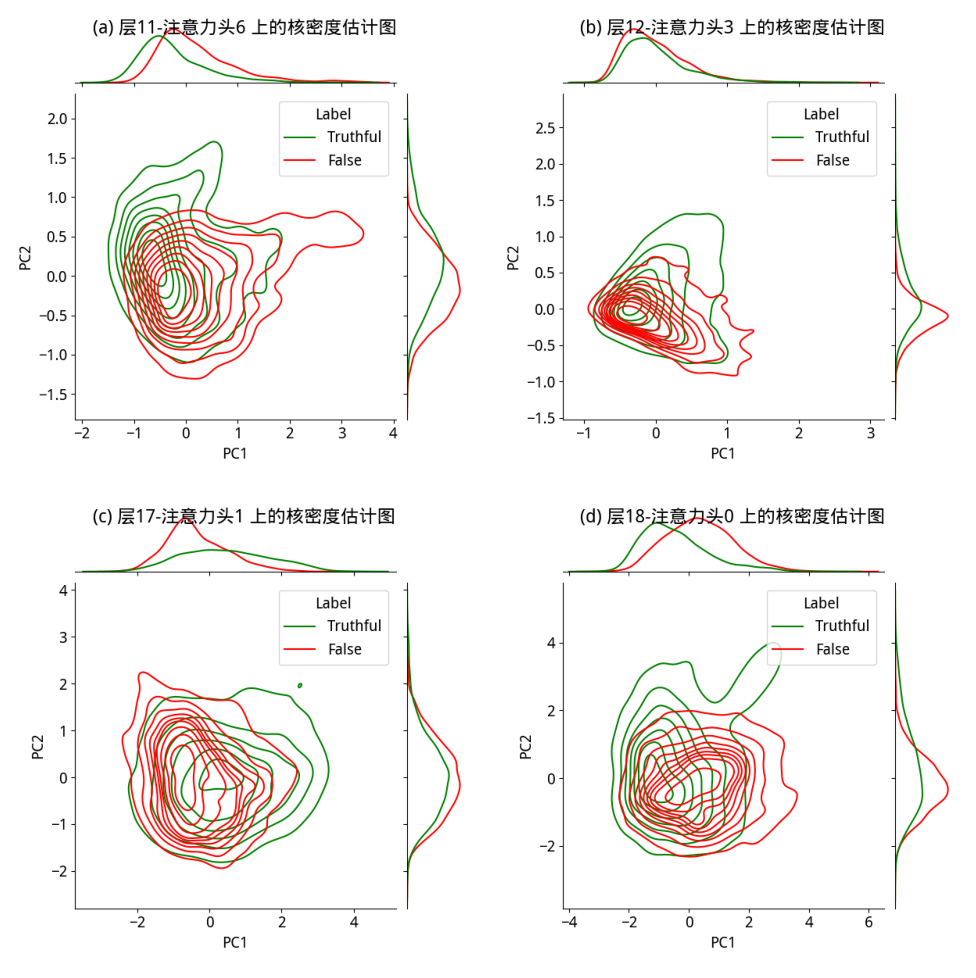

In [19]:
image_files = ['kde_11_6.png', 'kde_12_3.png', 'kde_17_1.png', 'kde_18_0.png']

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# 遍历图像文件和坐标轴，显示每个图像
for ax, img_file in zip(axes.flatten(), image_files):
    img = mpimg.imread(img_file)
    ax.imshow(img)
    ax.axis('off')  # 关闭坐标轴

plt.tight_layout()
plt.savefig('activations_kde.pdf', format='pdf')
plt.show()


# 可视化 “真理” 子类方向聚类效果

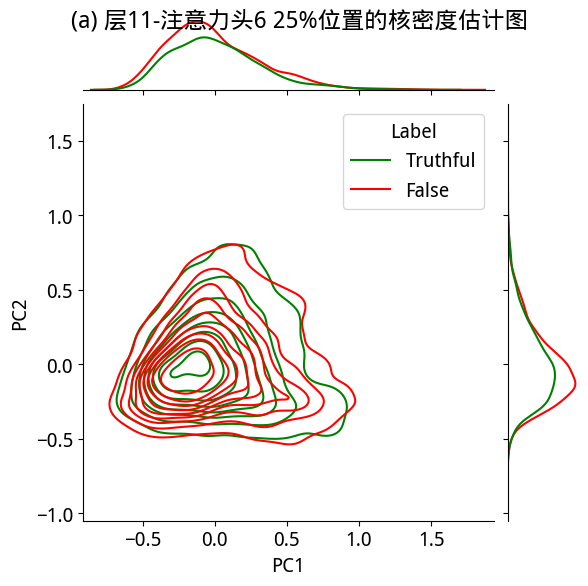

In [33]:
plot_kde(activation_head_wise, activation_labels, 11, 6)

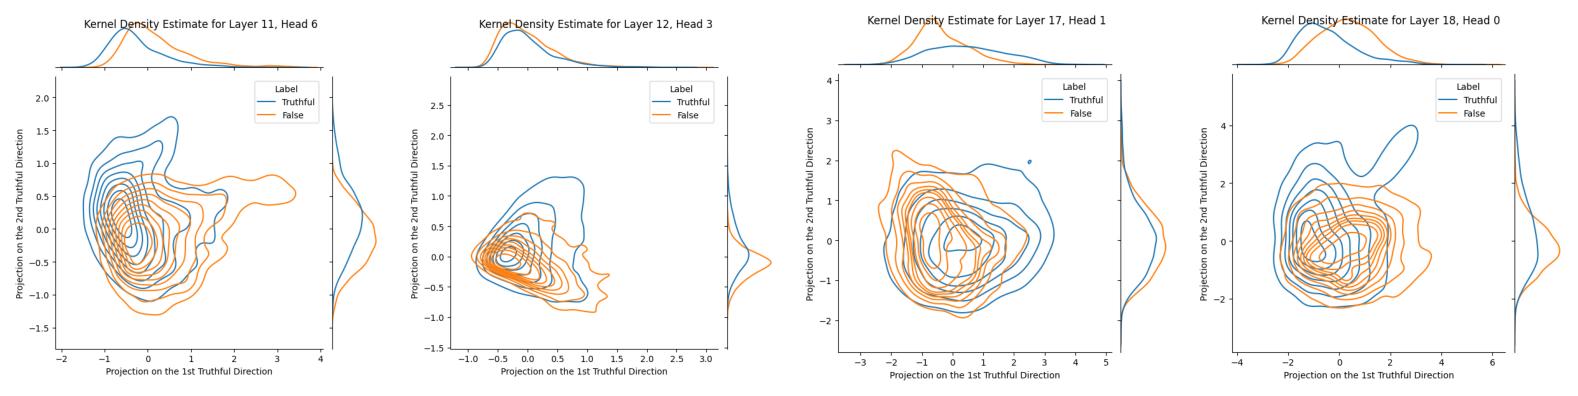

In [59]:
image_files = ['kde11_6.png', 'kde12_3.png', 'kde17_1.png', 'kde18_0.png']
plt.figure(figsize=(16, 8))

# 循环读取并显示每张图片
for i, image_file in enumerate(image_files):
    img = mpimg.imread(image_file)
    plt.subplot(1, 4, i + 1)  # 1行4列
    plt.imshow(img)
    plt.axis('off')  # 不显示坐标轴

# 调整子图间距
plt.tight_layout()
plt.savefig('activations_kde.pdf', format='pdf')
plt.show()


In [24]:
separated_head_wise_activations, separated_labels, separated_categories, idxs_to_split_at = get_separated_activations(activation_labels, activation_head_wise,activation_categories)

Found cached dataset truthful_qa (/home/jxf/.cache/huggingface/datasets/truthful_qa/multiple_choice/1.1.0/63502f6bc6ee493830ce0843991b028d0ab568d221896b2ee3b8a5dfdaa9d7f4)
100%|██████████| 1/1 [00:00<00:00, 512.13it/s]


In [25]:
directions, categories = get_sample_directions(separated_labels, separated_head_wise_activations, separated_categories, 11, 6)

/home/jxf/anaconda3/envs/iti/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_40640/53028448.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[-1].set_xticklabels(all_categories, rotation=90)


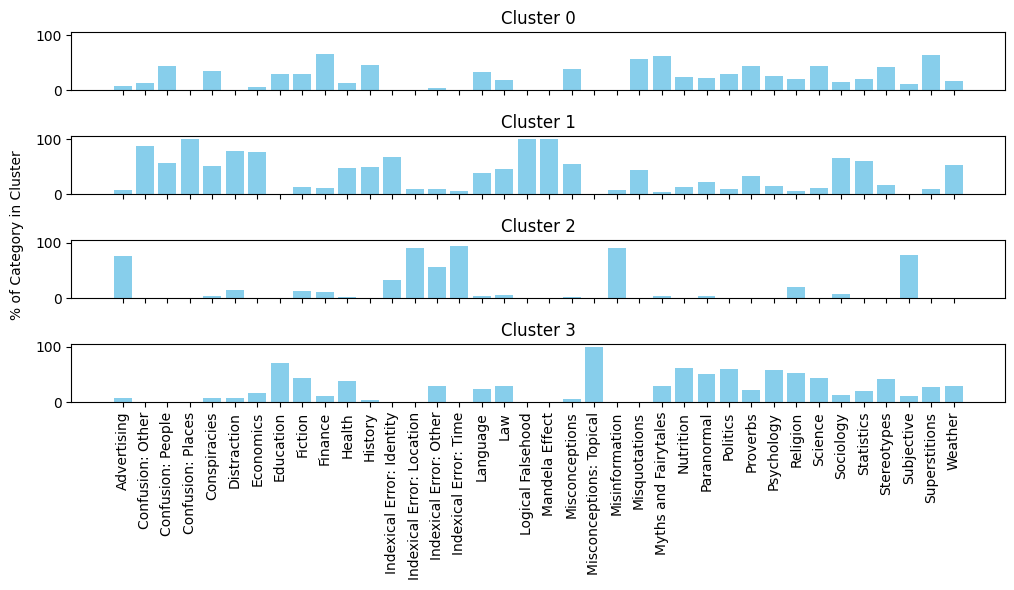

In [33]:
direction_kmeans_categorie_dist(directions, categories, n_clusters=4)

# 可视化 question 的聚类效果

In [7]:
num_heads = 32

q_activation_head_wise = pkl.load(open('/data/jxf/activations/llama_7B_tqa_mc2_question_head_wise.pkl', 'rb'))
q_activation_head_wise = np.array(q_activation_head_wise)
q_activation_head_wise = rearrange(q_activation_head_wise, 'b l (h d) -> b l h d', h = num_heads)
activation_labels = np.load('/data/jxf/activations/llama_7B_tqa_mc2_all_100_labels.npy')
activation_categories = pkl.load(open('/data/jxf/activations/llama_7B_tqa_mc2_all_categories.pkl', 'rb'))

/home/jxf/anaconda3/envs/iti/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_40640/53028448.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[-1].set_xticklabels(all_categories, rotation=90)


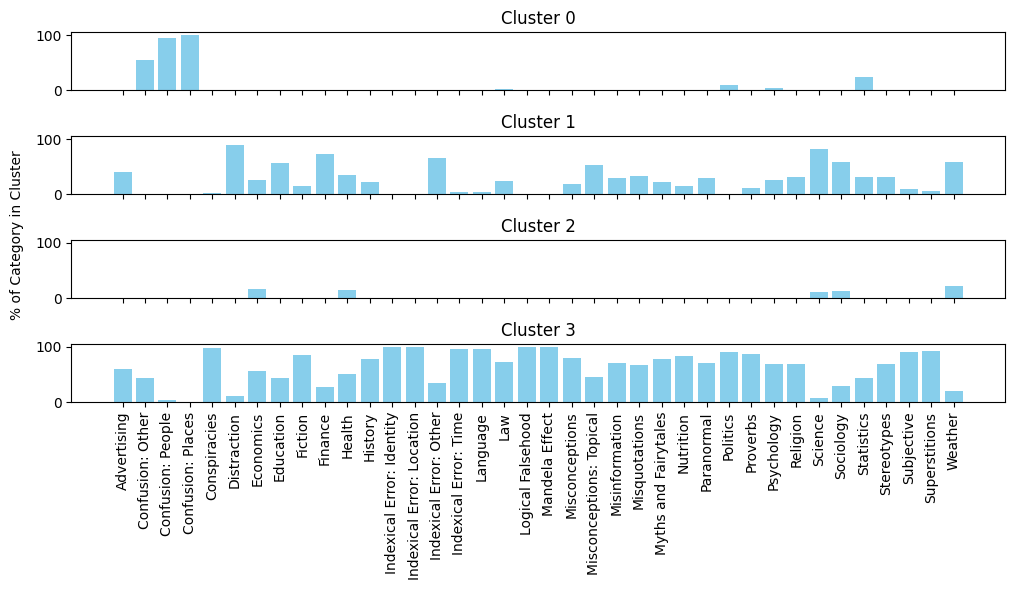

In [36]:
direction_kmeans_categorie_dist(q_activation_head_wise[:, 11, 6, :], activation_categories, n_clusters=4)